<a href="https://colab.research.google.com/github/Jiayu-Kang/Content-Analysis-homework/blob/main/8_Conversation_and_Text_Generation_jiayuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [3]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-0ofd4oda
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-0ofd4oda


In [2]:
pip install transformers

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
     |████████████████████████████████| 6.5 MB 16.6 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 30.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import seaborn as sns
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os
import io
import zipfile

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

In [5]:
%matplotlib inline

In [6]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

# ConvoKit
As we alluded to in Week 6 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [ ]:
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

     |████████████████████████████████| 167 kB 4.7 MB/s 
     |████████████████████████████████| 6.0 MB 1.4 MB/s 
     |████████████████████████████████| 1.5 MB 36.1 MB/s 
     |████████████████████████████████| 235 kB 39.8 MB/s 
     |████████████████████████████████| 53 kB 742 kB/s 
     |████████████████████████████████| 174 kB 38.3 MB/s 
     |████████████████████████████████| 749 kB 46.1 MB/s 
     |████████████████████████████████| 181 kB 44.3 MB/s 
     |████████████████████████████████| 628 kB 58.1 MB/s 
     |████████████████████████████████| 451 kB 50.9 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 10.1 MB 30.7 MB/s 
  Created wheel for convokit: filename=convokit-2.5.3-py3-none-any.whl size=204129 sha256=d7f5c2c3ab41f563b3a28f4329a4a766eae1f8051b8372e5f7456f9caefd5f36
  Stored in directory: /root/.cache/pip/wheels/b0/e8/2d/81c4477fe586fe4dad2de2886b990e90e839ffccd5158ed0f3
  Created wheel for emoji: filename=emoji-1.6.3

In [ ]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [ ]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

Dataset already exists at /root/.convokit/downloads/subreddit-Cornell


In [ ]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [ ]:
# This is a Reddit thread
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.Cornell',
 'gilded': 0,
 'gildings': None,
 'num_comments': 11,
 'stickied': False,
 'subreddit': 'Cornell',
 'timestamp': 1378883977,
 'title': 'Any League of Legends players at Cornell?'}

In [ ]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': None,
 'permalink': '',
 'retrieved_on': 1430719023,
 'score': 3,
 'stickied': False,
 'subreddit': 'Cornell',
 'top_level_comment': 'c7ithml'}

In [ ]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f737a5de3d0>, 'id': 'ericandre1213'})

In [ ]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': "What's it like starting a running a club?", 'num_comments': 11, 'domain': 'self.Cornell', 'timestamp': 1505058218, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f737a5de3d0>, 'id': '6z8x94'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Cornell Specific Ethernet Cable?', 'num_comments': 15, 'domain': 'self.Cornell', 'timestamp': 1505581606, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f737a5de3d0>, 'id': '70i159'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Key found on sidewalk outside of Utea in Collegetown', 'num_comments': 1, 'domain': 'self.Cornell', 'timestamp': 1535228132, 'subreddit': 'Cornell', 'gilded': 0, 'gild

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [ ]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

Why the **** is the fire alarm blaring
EDIT: Holy shit theres an actual fire

    Is it bad that I stayed in my dorm the whole time? Idk what floor it was on but 

        Seeing how that's actually how people die, that's bad. It's not even cold outsid

        [deleted]

        It's bad. Go outside. Alarms, especially in the middle of the night, go off for 

            Exactly - at least dorms today have some form of enhanced protection, but there 

    Which dorm was this?

        Dickson 

            what happened?

                Fire

    Clara Dickson 

    So 4:40 YOLO blaze it?

    Oh that's pretty early in the evening.



There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

In [ ]:
corpus = Corpus(download('subreddit-TrueFilm'))

Dataset already exists at /root/.convokit/downloads/subreddit-TrueFilm


In [ ]:
corpus.print_summary_stats()

Number of Speakers: 40221
Number of Utterances: 368058
Number of Conversations: 21214


In [ ]:
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.TrueFilm',
 'gilded': 0,
 'gildings': None,
 'num_comments': 3,
 'stickied': False,
 'subreddit': 'TrueFilm',
 'timestamp': 1513239151,
 'title': 'Question about Personal Shopper'}

In [ ]:
corpus.random_utterance().meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': None,
 'permalink': '',
 'retrieved_on': 1473503158,
 'score': 1,
 'stickied': False,
 'subreddit': 'TrueFilm',
 'top_level_comment': 'd6kuodp'}

In [ ]:
corpus.random_speaker().meta
# also no speaker metadata here

{}

In [ ]:
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f734bbbbf10>, 'id': 'Sovietfunion'})

In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'On African-Americans in Mainstream Film', 'num_comments': 80, 'domain': 'self.TrueFilm', 'timestamp': 1356463658, 'subreddit': 'TrueFilm', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f734bbbbf10>, 'id': '15fj9k'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'True Comedies of 2012?', 'num_comments': 97, 'domain': 'self.TrueFilm', 'timestamp': 1356409814, 'subreddit': 'TrueFilm', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f734bbbbf10>, 'id': '15eo4x'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': "The Story of Film: An Odyssey -- A 15 hour documentary now on Netflix instant, in 15 episodes. I'd like to discuss it a little.", 'num_comments': 41, 'domain': 'self.TrueFilm'

In [ ]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

http://vimeo.com/25815756

    I honestly thought that was one of the most ridiculous things I've ever heard. 

        What do you mean?

            Well I'm really tired so my already modest ability to articulate is dampened but

                Actually, he says the movie offends him because he doesn't believe such a subjec

                    I guess it's how you interpret things. I understand money so therefor I know tha

                        So you find it ridiculous to believe that someone shouldn't use something like t

                            I don't know, you can easily argue that the cheap tricks used in "Jaws" are insu

                                I'd like to mention that I never said I agree with Haneke or Verhoeven fully, I 

                                    It *might* be that I'm derailing the matter a bit, for which I apologize. I just

                                        Okay, now we're talking about something, and you make an excellent point in tha

In [ ]:
spkr.get_utterances_dataframe().head()

,timestamp,text,speaker,reply_to,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text,vectors
id,,,,,,,,,,,,,,,
c7lu0e5,1356419832,It's funny if you understand films. It's scary...,hobbitnamedfrod0,c7lt1t7,15eo4x,18,c7lsno2,1435654545,0,None,TrueFilm,False,,,[]
c7m0est,1356466326,If there's a race that is under-represented in...,hobbitnamedfrod0,15fj9k,15fj9k,49,c7m0est,1430768655,0,None,TrueFilm,False,,,[]
c7m0mg4,1356467370,I thought about Asian-Americans but Asia at le...,hobbitnamedfrod0,c7m0hjx,15fj9k,19,c7m0est,1430768755,0,None,TrueFilm,False,,,[]
c7mmsq2,1356582240,Thank you for mentioning this. I haven't had a...,hobbitnamedfrod0,15hni3,15hni3,0,c7mmsq2,1430779493,0,None,TrueFilm,False,,,[]
c7mo6ie,1356588321,Confirmed,hobbitnamedfrod0,c7mm8rs,15hni3,3,c7mlw3l,1430780163,0,None,TrueFilm,False,,,[]


In [ ]:
corpus.get_conversations_dataframe().head()

,vectors,meta.title,meta.num_comments,meta.domain,meta.timestamp,meta.subreddit,meta.gilded,meta.gildings,meta.stickied,meta.author_flair_text
id,,,,,,,,,,
1dibqs,[],Discussion: Shane Black as a director,9,self.TrueFilm,1367444389,TrueFilm,0,None,False,
1di8c1,[],Discussion of Quentin Tarantino's Direction,93,self.TrueFilm,1367441959,TrueFilm,0,None,False,
1di312,[],Odd occurences and motifs in An American Werew...,6,self.TrueFilm,1367438104,TrueFilm,0,None,False,
1dhl0a,[],Twilight vs Harry Potter: Why the massive cont...,9,self.TrueFilm,1367424734,TrueFilm,0,None,False,
1dhcmy,[],"Let's talk about Ben Affleck, the director",115,self.TrueFilm,1367417763,TrueFilm,0,None,False,


visualizing the conversation’s structure:

In [ ]:
convo.print_conversation_structure()

kittytime
    hobbitnamedfrod0
        kittytime
            hobbitnamedfrod0
                sjarrel
                    hobbitnamedfrod0
                        sjarrel
                            elbitjusticiero
                                sjarrel
                                    elbitjusticiero
                                        sjarrel
                                            elbitjusticiero
                    vegetableking
                        sjarrel
                            vegetableking
                                sjarrel
    moxy800
        Acglaphotis
            bjlyan
                Acglaphotis
                    bjlyan
    ooli
    [deleted]
        sjarrel
        heisengirl
            corporat
    gatzbysgreenlight
    admorobo
    prrulz
        50YearsofTea
    effrum
        kittytime
    Ghost_Dive
        harrythemay
    [deleted]
        kittytime
            [deleted]
                BrokenViolin
                kittytime
            

## Creating networks of agents from corpora

Now let's return to the Davies corpora (specifically, Soap Operas) to see how we can extract actors and build a network of their relationships in the texts.

We'll use the `lucem_illud.loadDavies()` function to get the dataframe. Make sure to download `SOAP.zip` from DropBox, unzip, and edit the following line with the path to that file. This code may take some time.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
corpora_address = "SOAP"

In [ ]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [ ]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 4th corpora, and I conducted my basic analysis on that.

In [ ]:
dool = soap_df['Tokenized Texts'][3]

In [ ]:
' '.join(dool[0:1500])

"@!Philip Seems like every time I look at you tonight you 're crying @!Chloe Tears of happiness I always thought that when I read Tears of Happiness what a crock But tonight you prove to me that they really do exist @!Philip I just carved our initials on that tree @!Chloe But it was so much more than that You took this angry outsider and you made her feel like a girl in a movie or a book a happy movie or a book @!Philip That 's what you deserve to be What gets me is that you do n't even realize how special you are @!Chloe All my life the word special was code for too weird for words And now here you are this great looking guy with a normal life and you make me believe like you really actually want me around @!Philip Oh that 's only half true @!Chloe Oh I 'm sorry @!Philip Oh no Chloe I want you around forever That 's so true but 's not true at all Except for you there 's nothing normal at all about my life @!Brenda We got to get the labs back on 23 @!Woman I 'll grab them @!Brenda Okay

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [ ]:
characters = {}

In [ ]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [ ]:
len(characters)

878

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [ ]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Philip 2846
Bo 4179
Shawn 2507
Hope 3793
Belle 2518
John 2542
Brady 2265
Marlena 2458
Nicole 2892
Kate 2503
Sami 5462
Lucas 2546


Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

In [ ]:
pwd

'/content/drive/MyDrive'

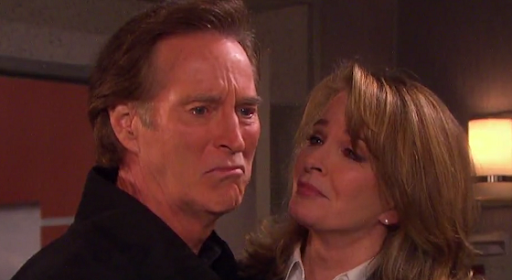

In [ ]:
Image(filename='/content/drive/MyDrive/data/dool/dool_john.png') 

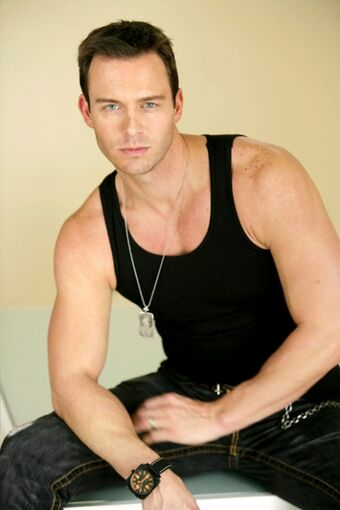

In [ ]:
Image(filename='/content/drive/MyDrive/data/dool/dool_brady.jpg') 

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_hope.jpeg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_philip.jpeg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_marlena.jpg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_kate.png')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_bo.png')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_chloe.jpg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_sami.jpg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_shawn.jpg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_belle.jpg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_lucas.jpg')

In [ ]:
# Image(filename='/content/drive/MyDrive/data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
len(actor_network.nodes.data())

12

In [ ]:
actor_network.nodes.data()

NodeDataView({'Philip': {'lines_spoken': 2846, 'words': []}, 'Bo': {'lines_spoken': 4179, 'words': []}, 'Shawn': {'lines_spoken': 2507, 'words': []}, 'Hope': {'lines_spoken': 3793, 'words': []}, 'Belle': {'lines_spoken': 2518, 'words': []}, 'John': {'lines_spoken': 2542, 'words': []}, 'Brady': {'lines_spoken': 2265, 'words': []}, 'Marlena': {'lines_spoken': 2458, 'words': []}, 'Nicole': {'lines_spoken': 2892, 'words': []}, 'Kate': {'lines_spoken': 2503, 'words': []}, 'Sami': {'lines_spoken': 5462, 'words': []}, 'Lucas': {'lines_spoken': 2546, 'words': []}})

In [ ]:
actor_network.nodes['Sami']['lines_spoken']

5462

In [ ]:
i = 0

The following lines of code creates the graph of actors and their relationships.

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

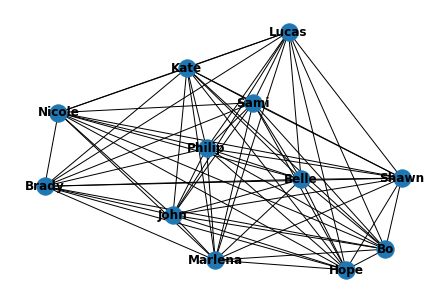

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

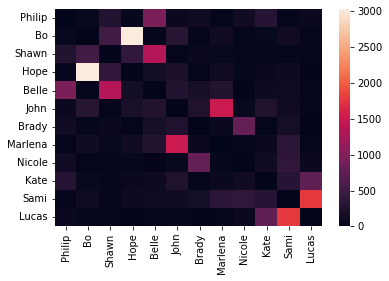

In [ ]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [ ]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'John',
            'Kate',
            'Lucas',
            'Marlena',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [ ]:
smaller_actor_network = nx.Graph()

In [ ]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


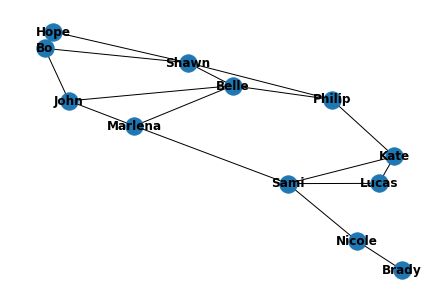

In [ ]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [ ]:
c

[frozenset({'Kate', 'Lucas', 'Philip', 'Sami'}),
 frozenset({'Bo', 'Hope', 'Shawn'}),
 frozenset({'Belle', 'John', 'Marlena'}),
 frozenset({'Brady', 'Nicole'})]

In [ ]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [ ]:
dcentralities['John'], dcentralities['Philip']

(0.2727272727272727, 0.2727272727272727)

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [ ]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [ ]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud.normalizeTokens(character_words))

In [ ]:
L = []

In [ ]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

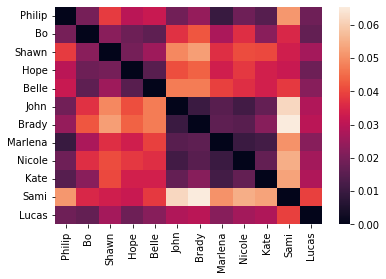

In [ ]:
fig = plt.figure()
div = pd.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
np.corrcoef(M_, M)[0]

array([ 1.        , -0.15659229,  0.77781138, -0.10048207, -0.12663172,
       -0.08122789,  0.0452386 ,  0.00113666, -0.18821411, -0.24789866,
       -0.11526811, -0.11290618,  0.26402906, -0.18822315, -0.21197682,
       -0.23750693, -0.60548622,  0.29225934,  0.24329836,  0.33789832,
        0.18169751,  0.1279459 , -0.00993151,  0.05373638])

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = '/content/drive/MyDrive/data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [ ]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [ ]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

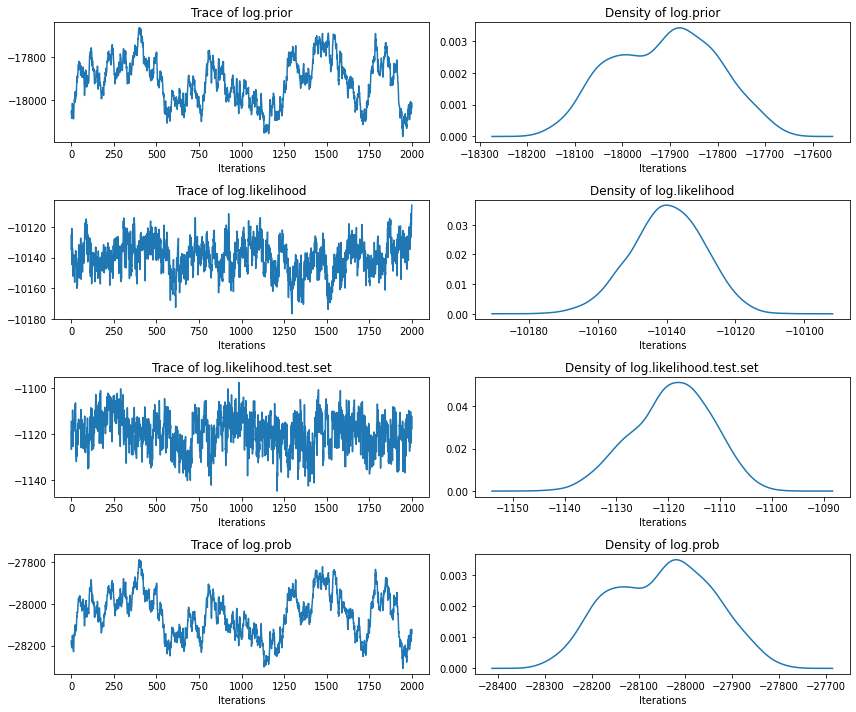

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


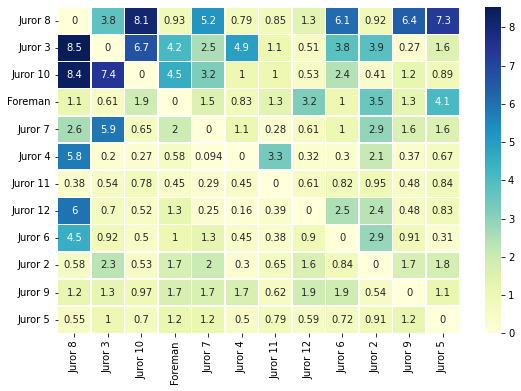

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


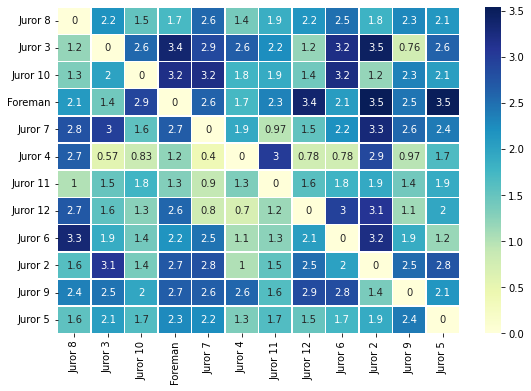

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


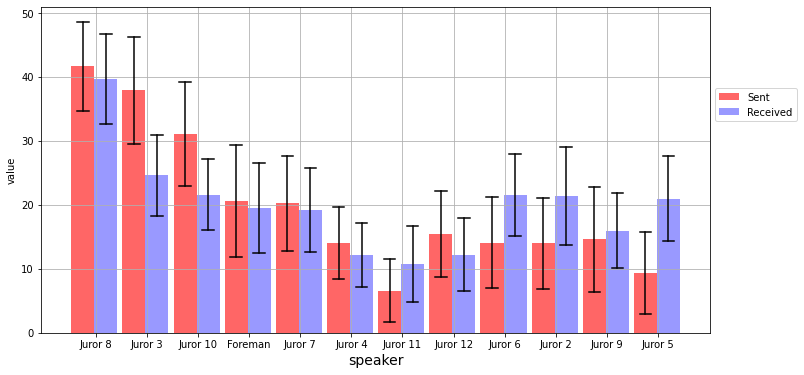

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


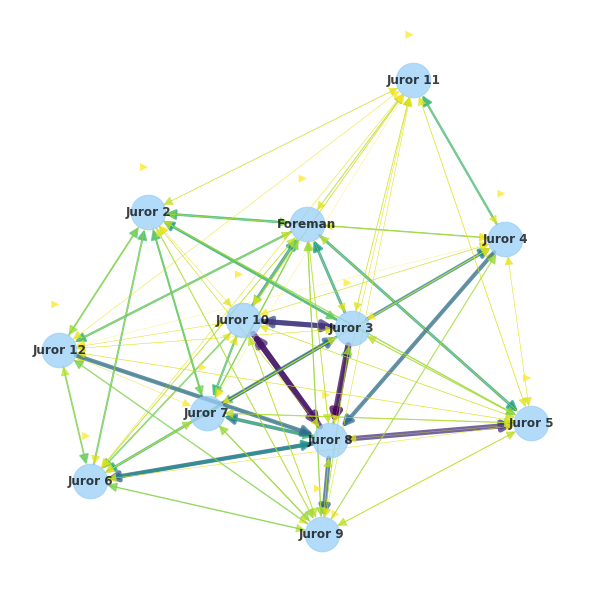

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


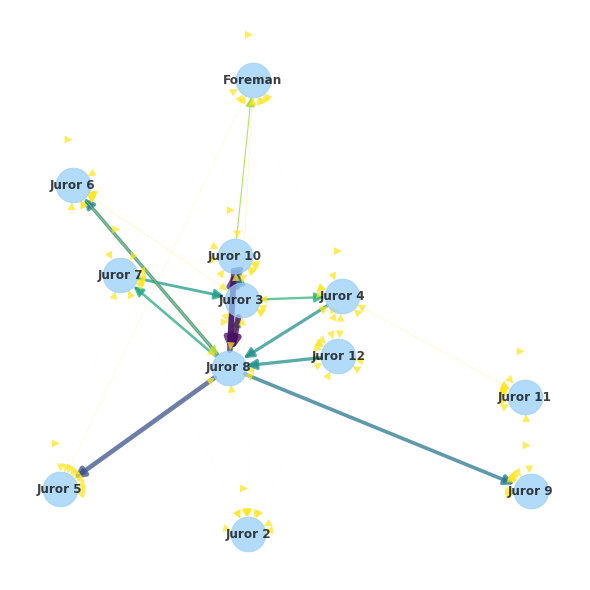

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


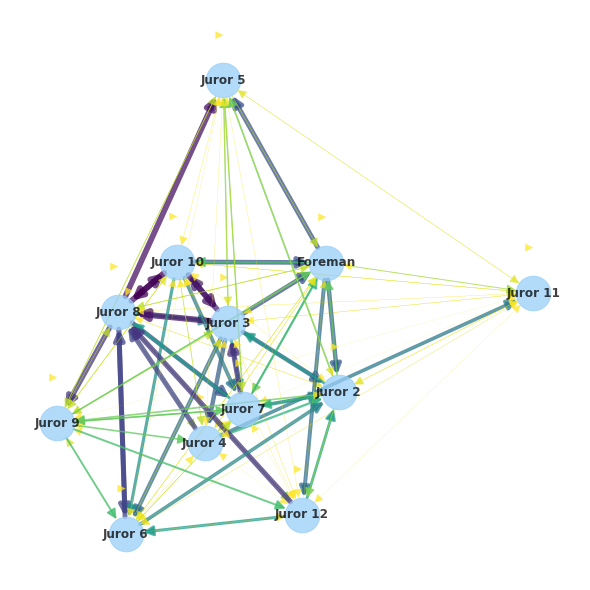

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,Trump,"[dlbs, adke, iglf, gghd, ighg, gdia, lfel, keb...",0.81831,1.297685
1,Bush,"[sssd, cisj, jged, akjk, hhai, cgig, ahjl, jlg...",2.39317,3.633416


Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

Below I'm doing an social influence analysis on the movie dialogue corpus on convokit, using the same set of criteria from this week's class activity (echos of power). I'm insterested in the gender power dynamics in movies.

In [ ]:
corpus = Corpus(filename=download("movie-corpus"))

In [159]:
print(corpus.random_speaker())

Speaker(id: u2851, vectors: [], meta: {'character_name': 'CLAIRE', 'movie_idx': 'm188', 'movie_name': 'someone to watch over me', 'gender': 'f', 'credit_pos': '2'})


In [161]:
from convokit import Utterance, Corpus, Coordination, download

In [165]:
import matplotlib.patches as mpatches

In [163]:
def make_chart(a_scores, b_scores, a_description, b_description, a_color="b", b_color="g"):
    # get scores by marker and on aggregate
    a_score_by_marker = a_scores["marker_agg2"]
    a_agg1, a_agg2, a_agg3 = a_scores["agg1"], a_scores["agg2"], a_scores["agg3"]
    b_score_by_marker = b_scores["marker_agg2"]
    b_agg1, b_agg2, b_agg3 = b_scores["agg1"], b_scores["agg2"], b_scores["agg3"]

    # the rest plots this data as a double bar graph
    a_data_points = sorted(a_score_by_marker.items())
    b_data_points = sorted(b_score_by_marker.items())
    a_data_points, b_data_points = zip(*sorted(zip(a_data_points, b_data_points),
        key=lambda x: x[0][1], reverse=True))
    labels, a_data_points = zip(*a_data_points)
    _, b_data_points = zip(*b_data_points)

    labels = ["aggregate 1", "aggregate 2", "aggregate 3"] + list(labels)
    a_data_points = [a_agg1, a_agg2, a_agg3] + list(a_data_points)
    b_data_points = [b_agg1, b_agg2, b_agg3] + list(b_data_points)

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(a_data_points)) + 0.35)
    ax.set_xticklabels(labels, rotation="vertical")

    ax.bar(np.arange(len(a_data_points)), a_data_points, 0.35, color=a_color)
    ax.bar(np.arange(len(b_data_points)) + 0.35, b_data_points, 0.35, color=b_color)

    b_patch = mpatches.Patch(color="b",
                             label=a_description + " (total: " +
                             str(a_scores["count_agg1"]) + ", " +
                             str(a_scores["count_agg2"]) + ")")
    g_patch = mpatches.Patch(color="g",
                             label=b_description + " (total: "  +
                             str(b_scores["count_agg1"]) + ", " +
                             str(b_scores["count_agg2"]) + ")")
    plt.legend(handles=[b_patch, g_patch])

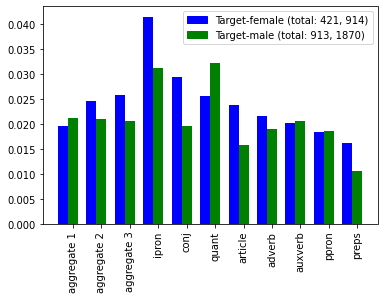

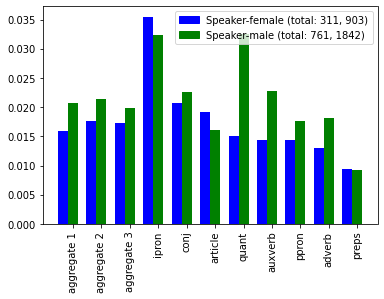

In [166]:
coord = Coordination()
coord.fit(corpus)

everyone = lambda speaker: True
female = lambda speaker: speaker.meta["gender"] == "f"
male = lambda speaker: speaker.meta["gender"] == "m"

make_chart(
    coord.summarize(corpus, everyone, female, focus="targets",
                    summary_report=True, target_thresh=7),
    coord.summarize(corpus, everyone, male, focus="targets",
                    summary_report=True, target_thresh=7),
    "Target-female", "Target-male"
)

make_chart(
    coord.summarize(corpus, female, everyone, summary_report=True,
                    speaker_thresh=7, target_thresh=7),
    coord.summarize(corpus, male, everyone, summary_report=True,
                    speaker_thresh=7, target_thresh=7),
    "Speaker-female", "Speaker-male"
)

Interestingly, the patterns in general indicates that people coordinate more to females, and on the on the other hand, males coordinate more to others.

## Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [27]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [6]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [7]:
dfs = []

In [11]:
for file in os.listdir("/content/drive/MyDrive/data/trump_tweets"):
    dfs.append(pd.read_json("/content/drive/MyDrive/data/trump_tweets/" + file))

In [12]:
df = pd.concat(dfs)

In [13]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for Android,550441250965708800,"""@ronmeier123: @Macys Your APPAREL is UNPARALL...",2014-12-31 23:59:55+00:00,8,NaN,21,False
1,Twitter for Android,550441111513493504,"""@gillule4: @realDonaldTrump incredible experi...",2014-12-31 23:59:22+00:00,5,NaN,18,False
2,Twitter for Android,550440752254562304,"""@JobSnarechs: Negotiation tip #1: The worst t...",2014-12-31 23:57:56+00:00,33,NaN,44,False
3,Twitter for Android,550440620792492032,"""@joelmch2os: @realDonaldTrump announce your p...",2014-12-31 23:57:25+00:00,8,NaN,26,False
4,Twitter for Android,550440523094577152,"""@djspookyshadow: Feeling a deep gratitude for...",2014-12-31 23:57:02+00:00,9,NaN,31,False


In [14]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [ ]:
train_text.head()

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [17]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [180]:
address = "C:/Downloads/GloWbE"

In [181]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [182]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

FileNotFoundError: ignored

In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

(WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE)


### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal.

#### Trump GPT-2

In [12]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [24]:
# You might have issues with the memory of your GPU in the following code.
# The default Google Colab GPU should work with batch size of 2,
# but if you get a "CUDA out of memory" error, you can reduce it to 1.

!python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
# !python run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
# !python run_language_modeling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

# If the GPU memory error still occurs even with a batch size of 1,
# you can need to run the code on RCC Midway
# (See https://github.com/UChicago-Computational-Content-Analysis/Frequently-Asked-Questions/issues/18)

03/08/2022 03:00:19 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
03/08/2022 03:00:19 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label

#### RoBERTa US

In [17]:
!python run_language_modeling.py --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

python3: can't open file 'run_language_modeling.py': [Errno 2] No such file or directory


#### RoBERTa UK

In [27]:
!python run_language_modeling.py --output_dir=output_roberta_gb --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

python3: can't open file 'run_language_modeling.py': [Errno 2] No such file or directory


(If you left to use a GPU machine, COME BACK TO THIS NOTEBOOK to load and work with your trained model.)

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [17]:
from transformers import AutoTokenizer, AutoConfig

In [26]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_trump

03/08/2022 03:01:07 - WARNING - __main__ - device: cuda, n_gpu: 1, 16-bits training: False
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py", line 1732, in from_pretrained
    user_agent=user_agent,
  File "/usr/local/lib/python3.7/dist-packages/transformers/file_utils.py", line 1929, in cached_path
    local_files_only=local_files_only,
  File "/usr/local/lib/python3.7/dist-packages/transformers/file_utils.py", line 2125, in get_from_cache
    _raise_for_status(r)
  File "/usr/local/lib/python3.7/dist-packages/transformers/file_utils.py", line 2046, in _raise_for_status
    raise RepositoryNotFoundError(f"404 Client Error: Repository Not Found for url: {request.url}")
transformers.file_utils.RepositoryNotFoundError: 404 Client Error: Repository Not Found for url: https://huggingface.co/output_gpt_trump/resolve/main/vocab.json

During handling of the above exception, another exception occurred:

Traceback (most re

In [33]:
tokenizer_trump = AutoTokenizer.from_pretrained("gpt2")
# If this line does not work, try tokenizer_trump = AutoTokenizer.from_pretrained("gpt2")

model_trump = AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [24]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a very good president," said Sen. John McCain (R-Ariz.). "He's going to be a very good president. He's going to be a very good president. He's going to be a very good


Quite the contrast.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [8]:
sample = pd.read_csv ('/content/drive/MyDrive/samplemoviereview.csv')

In [9]:
sample

,Unnamed: 0,productId,userId,score,helpfulness,year,text
0,0,B003AI2VGA,A141HP4LYPWMSR,3.0,1.0,2007,"Synopsis: On the daily trek from Juarez, Mexic..."
1,1,B003AI2VGA,A328S9RN3U5M68,3.0,1.0,2007,THE VIRGIN OF JUAREZ is based on true events s...
2,2,B003AI2VGA,A1I7QGUDP043DG,5.0,0.8,2006,The scenes in this film can be very disquietin...
3,3,B003AI2VGA,A1M5405JH9THP9,3.0,1.0,2007,THE VIRGIN OF JUAREZ (2006) directed by Kevin ...
4,4,B003AI2VGA,ATXL536YX71TR,3.0,1.0,2007,"Informationally, this SHOWTIME original is ess..."
...,...,...,...,...,...,...,...
995,995,B0001G6PZC,A3OXJB66H8LU8C,4.0,0.0,2004,"Rolling in late December 2003, this movie surp..."
996,996,B0001G6PZC,A2T7TZBOTP68C7,5.0,0.0,2004,The Last Samurai is one of the best movies I h...
997,997,B0001G6PZC,A258MSMKY2710V,4.0,0.0,2004,This is a very entertaining movie. good action...
998,998,B0001G6PZC,A1IBZ78E075W4S,5.0,0.0,2004,I am not especially a big Tom Cruise fan but t...


In [10]:
train_text, test_text = train_test_split(sample['text'], test_size=0.2)
train_text.to_frame().to_csv(r'train_text_samplemoviereview', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_samplemoviereview', header=None, index=None, sep=' ', mode='a')

In [2]:
pip install datasets

In [1]:
pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-esde3cbr
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-esde3cbr
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [23]:
!python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_samplemoviereview --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_samplemoviereview --do_eval --eval_data_file=test_text_samplemoviereview

03/08/2022 04:18:25 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
03/08/2022 04:18:25 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label

In [24]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_samplemoviereview

03/08/2022 04:25:48 - WARNING - __main__ - device: cuda, n_gpu: 1, 16-bits training: False
03/08/2022 04:25:53 - INFO - __main__ - Namespace(device=device(type='cuda'), fp16=False, k=0, length=20, model_name_or_path='output_gpt_samplemoviereview', model_type='gpt2', n_gpu=1, no_cuda=False, num_return_sequences=1, p=0.9, padding_text='', prefix='', prompt='', repetition_penalty=1.0, seed=42, stop_token=None, temperature=1.0, xlm_language='')
Model prompt >>> I love this movie because
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
=== GENERATED SEQUENCE 1 ===
I love this movie because it has several intriguing moments as the Japanese are ignorant and ignorant in their understanding of cultural change within Japan


The run_generation seems to provide meaningful outcome. The sample I used here is small and there happen to be reviews on movies in Japanese context - maybe that's why the words "Japanese" and "Japan" are produced and it talks about cultural change. For my final project I'll use the larger dataset to train the model.

In [28]:
tokenizer = AutoTokenizer.from_pretrained("output_gpt_samplemoviereview")
# If this line does not work, try tokenizer_trump = AutoTokenizer.from_pretrained("gpt2")

model = AutoModelWithLMHead.from_pretrained("output_gpt_samplemoviereview")

In [29]:
sequence = "I love this movie because"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

I love this movie because it's so much more than just a movie. It's a story of love, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal, betrayal,


In [30]:
sequence = "I love this movie because"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

I love this movie because it's so much more than just a movie. It's a movie about a man who is a man who is a man who is a man who is a man who is a man who is a man who is a man


Both returned some meaningful text about why one loves a movie. Interestingly, the movie review model mentioned the topic of "love and betrayal", while the untrained gpt2 model gives "a man who is a man" - sounds like nonsense but at least we know it's about a man...

Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [35]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [ ]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

In [ ]:
text = "Do you have your chips with fish or with salsa?" 

In [ ]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [ ]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [ ]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

In [ ]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

In [ ]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

## <font color="red">*Exercise 4*</font>

<font color="red">What's a research question relevant to your final project that would benefit from a generative or conversational model like GPT-2 or GPT-3? What task would you have it perform, and how would you evaluate the ouput?
    
<font color="red">_Stretch:_ Do it!

One set of research questions I can think of is: what are the best & worst movie stories/plots/scenes/act? 
To answer this open-ended question, I will train a language training model using Amazon movie review, and generate text that can reflect answers to the questions. It wouls also be interesting to compare the results with results generated by an untrained model and see whether/how they are different. (something like an extension to what I've done in the previous exercise).

# Optional: AI Dungeon
A fun way to explore the power of conversation and text generation is [AI Dungeon](https://play.aidungeon.io/main/newGame). If you select _Quick Start_, you can start a text adventure similar to the popular role-playing game Dungeons and Dragons, or the "choose your own adventure" books some of us boomers read as kids. AI Dungeon used to use GPT-2 but now uses GPT-3 to generate text in response to your actions. For example, you may begin with the prompt:

```
You are Jimmy, a wizard living in the kingdom of Larion. You have a staff and a spellbook. You finish your long journey and finally arrive at the ruin you've been looking for. You have come here searching for a mystical spellbook of great power called the book of essence. You look around and see a beautiful woman with raven hair and dark, sparkling eyes. She approaches you and asks you what you seek.

You are now before the one known as Raven.
```

You can respond with any text. I type, `I ask Raven, "What is the meaning of life?"`, to which AI Dungeon says:

```
Raven ponders the question for a moment, and then she answers. Raven says, "It is the pursuit of happiness." What is the pursuit of happiness?
```

I type, `I respond, "Happiness to me would be unearthing the treasures of the Kilarean Empire."`:

```
Raven looks at me and says, "Come with me and live out your one true life."

You go with Raven through many passages and up and down elevators.
```

Raven might be helping me unearth the treasures! Not bad!

There are a lot of tools like AI Dungeon being developed now with state-of-the-art language models. Now that you have some understanding of deep language models, you can better appreciate them—and perhaps design some of your own!